<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/Test_Shopee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/calibretaliation/DeepLearning20211

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32811, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (345/345), done.
remote: Total 32811 (delta 202), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32811/32811), 1.69 GiB | 28.35 MiB/s, done.
Resolving deltas: 100% (260/260), done.
Checking out files: 100% (32430/32430), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install albumentations==0.4.6
! pip install sklearn

     |████████████████████████████████| 117 kB 5.2 MB/s 
     |████████████████████████████████| 948 kB 34.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=1a8b7cca35d3ca54300f9a7cfd69a8ebc77e03db145ba70f3005396c81028057
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
import time
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as F

import albumentations as A
import albumentations.pytorch
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [ ]:
train_df = pd.read_csv('./DeepLearning20211/data/train.csv')
test_df = pd.read_csv('./DeepLearning20211/data/test.csv')
train_img_path = './DeepLearning20211/data/train_images'
test_img_path = './DeepLearning20211/data/test_images'

In [ ]:
def my_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
my_seed(33)

In [ ]:
train_df['file_path'] = train_df.image.apply(lambda x: os.path.join(train_img_path, x))
train_df.head(5)

,posting_id,image,image_phash,title,label_group,file_path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,./DeepLearning20211/data/train_images/0000a688...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,./DeepLearning20211/data/train_images/00039780...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,./DeepLearning20211/data/train_images/000a190f...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,./DeepLearning20211/data/train_images/00117e4f...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,./DeepLearning20211/data/train_images/00136d1c...


In [ ]:
# Drop duplicate by p-hash
# train_df = train_df.drop_duplicates(subset=['image_phash'],keep = 'first')
train_df = train_df.reset_index()

In [ ]:
#check if label group preserved
train_df.label_group.value_counts()

994676122     51
159351600     51
562358068     51
3113678103    51
1163569239    51
              ..
3996065489     2
517023446      2
2101581536     2
3460538113     2
3927456083     2
Name: label_group, Length: 11014, dtype: int64

In [ ]:
le = LabelEncoder()
train_df.label_group = le.fit_transform(train_df.label_group)
train_df['label_group'].value_counts()

2606     51
8037     51
1445     51
412      51
2994     51
         ..
10795     2
4652      2
6701      2
558       2
8172      2
Name: label_group, Length: 11014, dtype: int64

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=1, stratify=Y)
train_df['index'] = train_df.index
val_df = train_df.sample(frac = 1, random_state = 24).groupby('label_group').nth(0)
val_df['label_group'] = val_df.index
val_df =val_df.set_index('index')
train_df = train_df.drop('index', axis = 1)
train_df = train_df.drop(index = val_df.index).reset_index(drop = True)
val_df = val_df.reset_index(drop = True)
print(len(val_df))
print(len(train_df))
print(len(train_df) + len(val_df))


11014
23236
34250


In [ ]:
class ShopeeDataset(Dataset):

    def __init__(self, dataframe, dir_path, mode, transforms):
        self.dataframe = dataframe
        self.dir_path = dir_path
        self.augmentations = transforms
        self.mode = mode
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_info = self.dataframe.iloc[index]
        img = cv2.imread(img_info.file_path)
        label = torch.tensor([img_info['label_group']])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=img)
            img = augmented['image']   

        if self.mode == 'test':
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), torch.tensor(img_info.label_group).int()
      

transforms_train = albumentations.Compose([ 
    albumentations.augmentations.transforms.Flip(),
    albumentations.augmentations.transforms.Cutout(),
    albumentations.augmentations.transforms.ShiftScaleRotate(rotate_limit=180, p=0.5, interpolation = cv2.INTER_LANCZOS4),
    albumentations.augmentations.transforms.Normalize( mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    albumentations.augmentations.transforms.Resize(224, 224), 
    ToTensorV2() 
    ])
transforms_valid = albumentations.Compose([
    albumentations.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    albumentations.Resize(224, 224),
    ToTensorV2()
])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for flo

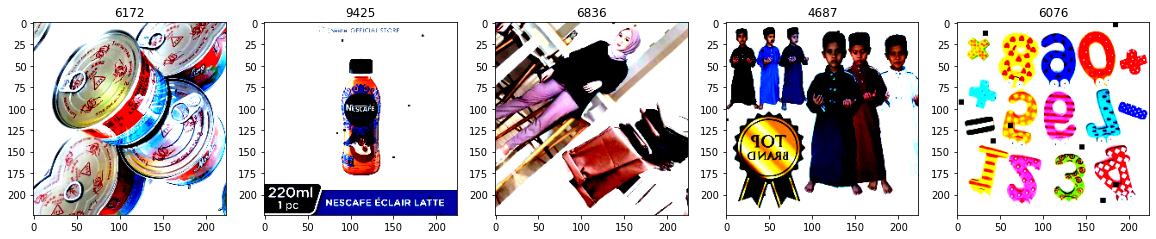

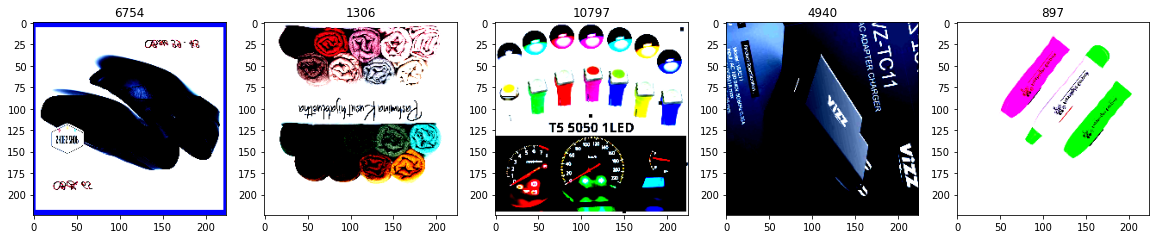

In [ ]:

train_ds = ShopeeDataset(train_df, train_img_path, 'train' , transforms_train)
valid_ds = ShopeeDataset(val_df, train_img_path, 'valid' , transforms_train)

train_loader = DataLoader(train_ds, batch_size = 4, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 4, shuffle = True)

for i in range(2):
    f, axarr = plt.subplots(1,5, figsize = (20,4))
    for p in range(5):
        idx = i*5 + p
        img, label = train_ds[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.item())

In [ ]:
class BottleNeck(nn.Module):
    def __init__(self, input_size, growthRate):
        super(BottleNeck,self).__init__()
        outChannels = 4*growthRate
        self.bn1 = nn.BatchNorm2d(input_size)
        self.conv1 = nn.Conv2d(input_size, outChannels, kernel_size = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(outChannels)
        self.conv2 = nn.Conv2d(outChannels, growthRate, kernel_size = 3, bias = False, padding = 1)
    def forward(self, x):
        out = self.bn1(x)
        #print("Batch normalize 1", out.shape)
        out = self.conv1(F.relu(out))
        #print("conv 1", out.shape)        
        out = self.bn2(out)
        #print("Batch normalize 2", out.shape)
        out = self.conv2(F.relu(out))
        #print("conv 2", out.shape)  
        out = torch.cat((out,x),1)
        #print("cat", out.shape)  
        return out

class SingleLayer(nn.Module):
    def __init__(self, input_size, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(input_size)
        self.conv1 = nn.Conv2d(input_size, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.bn1(x)
        out = self.conv1(F.relu(out))
        #out = torch.cat((x, out), 1)
        return out

class TransitionLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(TransitionLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(input_size)
        self.conv1 = nn.Conv2d(input_size, output_size, kernel_size = 1, bias = False)
    def forward(self, x):
        out = self.bn1(x)
        out = self.conv1(F.relu(out))
        out = F.avg_pool2d(out, 2)
        return out

class DenseNetShopee(nn.Module):
    def __init__(self, growthRate, reduction, num_classes, bottleneck):
        super(DenseNetShopee, self).__init__()
        num_channels = 2*growthRate
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=7, stride = 2, padding = 3, bias=False)
        self.pooling1 = nn.AvgPool2d(kernel_size = 3, stride = 2, padding = 1)


        self.dense1 = self._make_dense(num_channels, growthRate, 6, bottleneck)
        num_channels += 6*growthRate
        nOutChannels = int(math.floor(num_channels*reduction))
        self.trans1 = TransitionLayer(num_channels, nOutChannels)

        num_channels = nOutChannels
        self.dense2 = self._make_dense(num_channels, growthRate, 12, bottleneck)
        num_channels += 12*growthRate
        nOutChannels = int(math.floor(num_channels*reduction))
        self.trans2 = TransitionLayer(num_channels, nOutChannels)

        num_channels = nOutChannels
        self.dense3 = self._make_dense(num_channels, growthRate, 6, bottleneck)
        num_channels += 6*growthRate
        nOutChannels = int(math.floor(num_channels*reduction))
        self.trans3 = TransitionLayer(num_channels, nOutChannels)
        num_channels = nOutChannels

        self.single = SingleLayer(num_channels, growthRate)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.flatten = nn.Flatten(1)
        self.fc = nn.Linear(1568, num_classes)
        self.activate = nn.Softmax()
    def forward(self, x):
        #print('x', x.shape)
        x = self.conv1(x)
        #print('Conv1', x.shape)
        x = self.pooling1(x)
        #print('Pooling1 ', x.shape)
        x = self.dense1(x)
        #print('Dense 1',x.shape)
        x = self.trans1(x)
        #print('Trans 1', x.shape)
        x = self.dense2(x)
        #print('Dense 2', x.shape)
        x = self.trans2(x)
        #print('Trans 2', x.shape)
        x = self.dense3(x)
        #print('Dense 3', x.shape)
        #x = torch.squeeze(x, dim = 183)
        x = self.trans3(x)
        #print('Trans 3', x.shape)
        x = self.single(x)
        #print('Single ', x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #x = self.activate(x)
        x = nn.Dropout(p = 0.2)(x)

        return x

    def _make_dense(self, num_channels, growthRate, num_denseBlock, bottleneck):
        layer = []
        for i in range(num_denseBlock):
            if bottleneck:
                layer.append(BottleNeck(num_channels, growthRate))
            else: 
                layer.append(SingleLayer(num_channels, growthRate))
            num_channels += growthRate
        return nn.Sequential(*layer)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
num_classes = 11014
learning_rate = 0.1
batch_size = 64
display_step = 16
epochs = 10
checkpoint = '/content/drive/MyDrive/Colab Notebooks/Densenet.pth' #SAVE IN PERSONAL DRIVE< PLS CHANGE BEFORE RUNNING

Using cuda device


In [ ]:
try: # load model
  model = DenseNetShopee(32, 1, num_classes, bottleneck = True).to(device)
  criterion = nn.CrossEntropyLoss()
  cp = torch.load(checkpoint)
  model.load_state_dict(cp['model_state_dict'])
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  optimizer.load_state_dict(cp['optimize_state_dict'])
  epoch = cp['epoch'] + 1 
  #loss = cp['loss']
  best_val_loss = cp['best_val_loss']
  print('Using loaded model')
except: 
  print("NGU")
  model = DenseNetShopee(32, 1, num_classes, bottleneck = True).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  best_val_loss = 999

#summary(model, (3,224,224))

Using loaded model


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)
best_val_loss = 999

In [ ]:
def train_loop(epoch, model, train_data_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_data_loader):
        data, target = data.to(device), target.to(device).to(torch.int64)
        optimizer.zero_grad() 
        output = model(data)
        loss = criterion(output, target)
        loss.backward() 
        optimizer.step()
        optimizer.zero_grad() 
        if batch_idx % display_step == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test_loop(model, test_data_loader):
    global best_val_loss
    model.eval()
    test_loss = 0
    correct = 0
    # set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device).to(torch.int64)
            output = model(data)
            output = F.log_softmax(output,dim=1) # log softmax dùng F, chú ý dim
            test_loss += criterion(output, target)
            pred = output.argmax(dim =1, keepdim = True) # argmax để lấy predicted label, chú ý dim, và keepdim = True
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_data_loader.dataset)
    correct /=  len(test_data_loader.dataset)
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(model.state_dict(),checkpoint) 
        print('*********** BEST VAL LOSS = {}   *************'.format(best_val_loss))
        print("***********   SAVEEEEEEE TEST_ACC = {}%    ***********".format(correct))         
    print("***********    TEST_ACC = {}%    ***********".format(correct))

In [ ]:
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = batch_size, shuffle = True)

In [ ]:
for epoch in range(epochs):
  train_loop(epoch, model, train_loader)
  test_loop(model, train_loader)

In [ ]:
def evaluateTopk(model, loader, k):
    if k == 1:
        start_time = time.time()
    model.eval()
    correct = 0
    total = len(loader.dataset)
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device).to(torch.int64)
            output = model(data)
            target_resized = target.view(-1,1)
            _, pred = output.topk(k, 1, True, True)
            correct += pred.eq(target_resized).sum().item()
            #print(pred.eq(target_resized).sum().item())
    print('Inference time: {} for top {}'.format(time.time() - start_time, k))
    return correct/len(loader.dataset)

In [ ]:
valid_bug_ds = ShopeeDataset(val_df[0:128], train_img_path, 'valid' , transforms_train)
valid_loader_bug = DataLoader(valid_bug_ds, batch_size = 64, shuffle = True)
print(evaluateTopk(model, valid_loader, 5))
print(evaluateTopk(model, valid_loader, 1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.0005447612130016343
Inference time: 680.9188256263733 for top 1
9.079353550027238e-05
